In [1]:
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from os.path import expanduser
#from lib.definitions.classdefinitions import *
import lib.definitions.classdefinitions as classdef
import lib.filter as filter
import lib.sqlite_load as sq
import lib.util as util
import lib.plot as plot
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import importlib
import numpy as np
import prettyprinter as pp
import importlib

FLOW_LABELS = [0, 255, 65280, 983040, 1048575]

logging.basicConfig(level=logging.CRITICAL)
vp = classdef.VantagePoint()
home = expanduser("~")
# Test/small data:
db_dir = home + "/git/scripts/stats/sample-data/db/*.db"
db_path = home + "/git/scripts/stats/sample-data/db/db-ubuntu-fra1-0-2023-01-22T17_04_15Z.db"
#importlib.reload(util)
#importlib.reload(filter)
#importlib.reload(classdef)


# Evaluation

# Vantage Point: ams (Amsterdam)

## Summary: table

In [2]:
import pandas as pd

table_data = {'Algothime': ['KNN', 'SVM', 'MLP'],
'Param. 1': ['-', '-', '-'],
'Param. 2': ['-', '-', '-'],
'Plage param. 1': ['-', '-', '-'],
'Plage param. 2': ['-', '-', '-']
}
df = pd.DataFrame(data=table_data)
print(df)

  Algothime Param. 1 Param. 2 Plage param. 1 Plage param. 2
0       KNN        -        -              -              -
1       SVM        -        -              -              -
2       MLP        -        -              -              -


## Summary: stats

In [14]:
test: bool = False
if test:
    df: pd.DataFrame = sq.load_single(db_path)
else:
    df: pd.DataFrame = sq.load_single("/home/erlend/db-storage/large-data/" + classdef.Databases.ams)
    #df: pd.DataFrame = sq.load_single("/home/erlend/db-storage/db-ubuntu-tor1-0-2023-01-22T17_28_09Z.db")
stats = util.create_stats(df)
pp.pprint(stats)

TracerouteStatistics(num_rows_total=155780, num_cycles=37108, num_cycle_rows=16841, num_loops=100372, num_loop_rows=49607, num_fl_changes=150, num_fl_change_rows=150, num_unique_asns_in_dataset=15649, num_invalid_rows=55808, n_traceroutes_to_the_same_destination_with_the_same_flow_label=2, num_vantage_points=8)


# Flow label persistence
### Does the flow label change in-transit?

In [25]:
def get_num_rows(df: pd.DataFrame) -> int:
    """
    Get total number of rows in the dataframe.
    """
    return len(df)

def count_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = returned_flow_labels.split(" ")
        for val in flow_labels:
            if src_fl != val:
                num_flow_label_changes += 1
    return num_flow_label_changes

print(f"Total number of rows: {get_num_rows(df)}")
print(f"Total number of flow label changes: {count_flow_label_changes(df)}")

Total number of rows: 155780
Total number of flow label changes: 150


# Counting loops
## How many loops were detected in the dataset?

In [4]:
def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def count_loops(df: pd.DataFrame) -> int:
    nloops = 0
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip: str = hop_ip_list[0]
        for ip in hop_ip_list[1:]:
            if ip == prev_ip:
                nloops += 1
            prev_ip = ip
    return nloops
result = count_loops(df)
pp.pprint(result)

100372


## How many rows (traces) contain a loop?

In [6]:
def count_loop_rows(df: pd.DataFrame) -> int:
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    indices.append(row_idx)
                    break
            prev_ip = ip
    return len(indices)

result = count_loop_rows(df)
pp.pprint(result)

49607


# Counting cycles
## How many cycles exist in the dataset?

In [10]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def count_cycles(df: pd.DataFrame) -> int:
    """
    Count the number of cycles in the dataset. If there are multiple 
    cycles in each row, each will be counted as a separate cycle.
    A cycle is where the same IP address appears twice, separated by 
    at least one other IP address.
    """
    cycle_count = 0
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    cycle_count += 1
    return cycle_count

num_cycles = count_cycles(df)
pp.pprint(num_cycles)

37108


## How many rows (traces) contain a cycle?

In [6]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def count_cycle_rows(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    indices.append(row_idx)
                    break # Uncomment this if we only want to count 1 cycle per row.
    return len(indices)

result = count_cycle_rows(df)
pp.pprint(result)

16841


# Filtering
## How many invalid traces do we have?
### Causes of invalid traces:
1. Loops
2. Cycles
3. Loop-siblings and cycle-sibings
4. Flow label changes in-transit

In [ ]:
def count_invalid_traces(df: pd.DataFrame) -> int:
    """
    Count traces containing loops, cycles and flow label values
    that changed in-transit.
    """
    loop_indices: list = get_loop_indices(df)
    cycle_indices: list = get_cycle_indices(df)
    fl_change_indices: list = get_rows_with_path_flow_label_changes(df)
    merged_list = loop_indices + cycle_indices + fl_change_indices
    # Remove duplicate entries
    merged_list = list(dict.fromkeys(merged_list))
    return len(merged_list)

result = count_invalid_traces(df)
print(result)

## How many invalid sibling-traces do we have?

In [7]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def get_rows_with_path_flow_label_changes(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return indices

def get_cycle_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    indices.append(row_idx)
                    # Uncomment this if we only want to count 1 cycle per row.
                    break
    return indices

def get_loop_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain loops in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    indices.append(row_idx)
                    break
            prev_ip = ip
    return indices

def get_invalid_traces_indices(df: pd.DataFrame):
    """
    Get a list containing the indicies of all rows
    with invalid traces.
    """
    loop_indices: list = get_loop_indices(df)
    cycle_indices: list = get_cycle_indices(df)
    fl_change_indices: list = get_rows_with_path_flow_label_changes(df)
    merged_list = loop_indices + cycle_indices + fl_change_indices
    # Remove duplicate entries
    merged_list = list(dict.fromkeys(merged_list))
    return merged_list

def find_sibling_indices_for_all(df: pd.DataFrame) -> list:
    """
    If one row is deemed to be invalid, we also have to remove
    its sibling row.
    """
    associated_rows = list()
    invalid_traces: list = get_invalid_traces_indices(df)
    for row_idx in invalid_traces:
        sibling_indices = find_sibling_indices_for_one(row_idx, df)
        #associated_rows.append(sibling_indices)
        associated_rows = associated_rows + sibling_indices
    return associated_rows

def find_sibling_indices_for_one(row_idx, df: pd.DataFrame) -> list:
    """
    Returns the indices (row-numbers) of a row's sibling.
    """
    indices = list()
    row_src_ip = df["SOURCE_IP"].iloc[row_idx]
    row_dst_ip = df["DESTINATION_IP"].iloc[row_idx]
    row_flow_label = df["SOURCE_FLOW_LABEL"].iloc[row_idx]
    for idx in df.index:
        if (df["SOURCE_IP"].iloc[idx] == row_src_ip) and (df["DESTINATION_IP"].iloc[idx] == row_dst_ip) and (df["SOURCE_FLOW_LABEL"].iloc[idx] == row_flow_label) and (idx != row_idx):
            indices.append(idx)
    return indices
 
def count_sibling_indices(df: pd.DataFrame) -> int:
    return len(find_sibling_indices_for_all(df))

#result = count_sibling_indices(df)
#print(result)

KeyboardInterrupt: 

## Drop invalid traces (rows)

In [18]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def get_rows_with_path_flow_label_changes(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return indices

def get_cycle_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    indices.append(row_idx)
                    # Uncomment this if we only want to count 1 cycle per row.
                    break
    return indices

def get_loop_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain loops in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    indices.append(row_idx)
                    break
            prev_ip = ip
    return indices

def get_invalid_traces_indices(df: pd.DataFrame):
    """
    Get a list containing the indicies of all rows
    with invalid traces.
    """
    loop_indices: list = get_loop_indices(df)
    cycle_indices: list = get_cycle_indices(df)
    fl_change_indices: list = get_rows_with_path_flow_label_changes(df)
    merged_list = loop_indices + cycle_indices + fl_change_indices
    # Remove duplicate entries
    merged_list = list(dict.fromkeys(merged_list))
    return merged_list

def get_sibling_indices(df: pd.DataFrame):
    sibling_indices = list()
    invalid_traces = get_invalid_traces_indices(df)
    for row_idx in invalid_traces:
        row_src_ip = df["SOURCE_IP"].iloc[row_idx]
        row_dst_ip = df["DESTINATION_IP"].iloc[row_idx]
        row_flow_label = df["SOURCE_FLOW_LABEL"].iloc[row_idx] 
        new_df = df[ (df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)]
        sibling_indices = sibling_indices + list(new_df.index)
    return sibling_indices

#print("len get_invalid_traces_indices")
#print(len(get_invalid_traces_indices(df)))
print("old row len:")
print(len(df.index))
df = df.drop(get_invalid_traces_indices(df))
print("new row len:")
print(len(new_df.index))

old row len:
155780
new row len:
99972


# Path consistency
## Do we get a consistent path by setting the flow label?

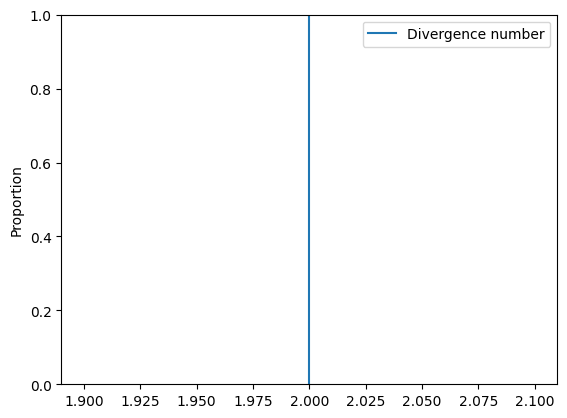

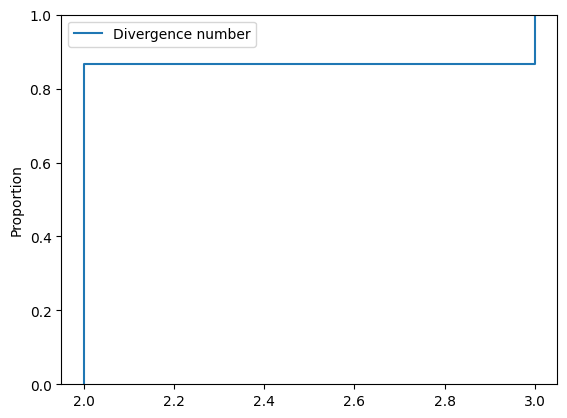

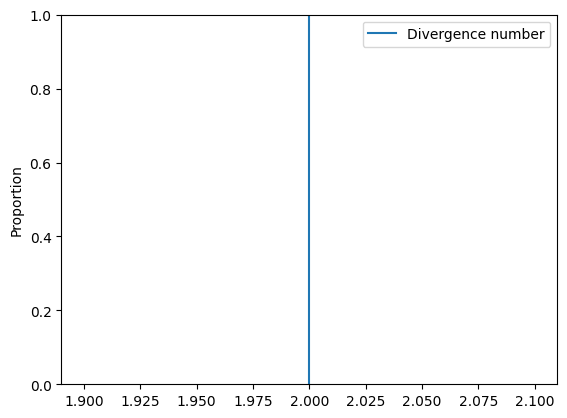

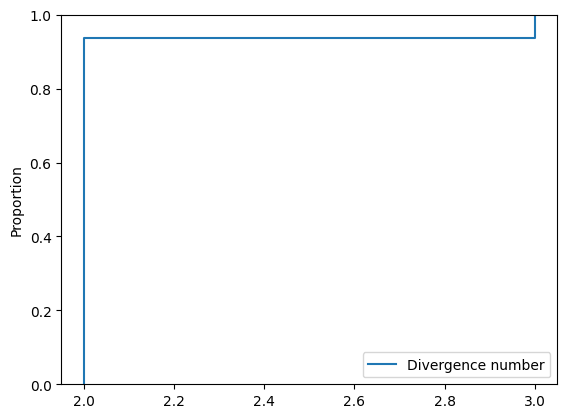

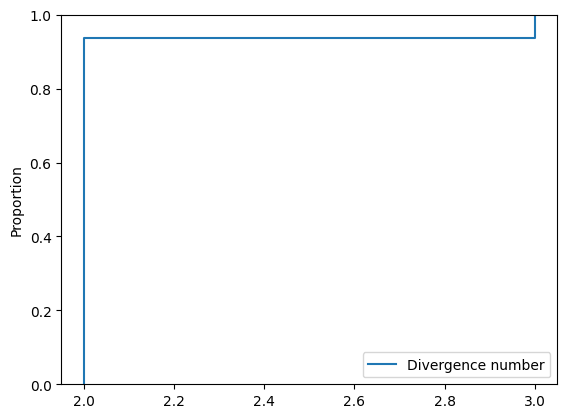

In [7]:
def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_path_hash_value_counts(
        df: pd.DataFrame, flowlabel: int) -> pd.Series:
    """
    Get a distribution of the number of paths to a destination.
    """
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    start_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel) & (
        df["DESTINATION_IP"] == str(unique_destination_addresses[0]))]
    base: pd.Series = start_df["PATH_HASH"].value_counts()
    for addr in unique_destination_addresses[1:]:
        next_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel)
                                   & (df["DESTINATION_IP"] == str(addr))]
        overlay: pd.Series = next_df["PATH_HASH"].value_counts()
        base = pd.concat([base, overlay], axis=0)
    logging.info(f"base value_counts:\n{base.value_counts().to_string()}")
    return base.value_counts()

for flow_label in FLOW_LABELS:
    dist = get_path_hash_value_counts(
        df, flowlabel=flow_label)
    fig, ax = plt.subplots()
    bars = ax.bar([str(i) for i in dist.index], dist)
    ax.bar_label(bars)
    plt.title(f"Vantage point: {classdef.VantagePoint.ams} \nFlow label: {flow_label}")

# If the paths diverge, at what hop does the divergence occur?

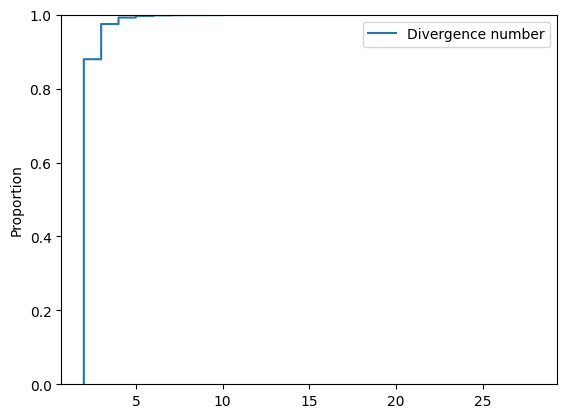

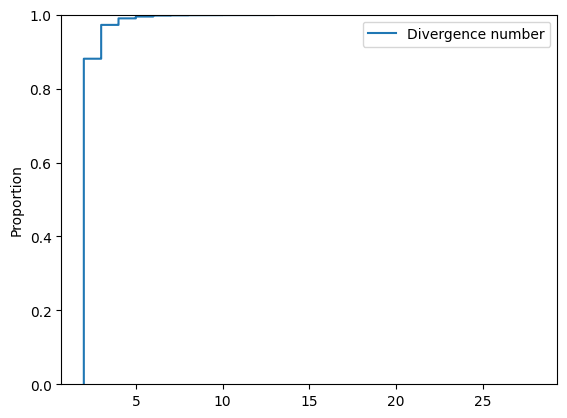

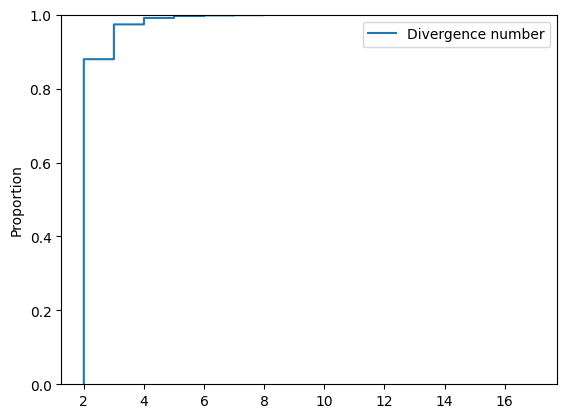

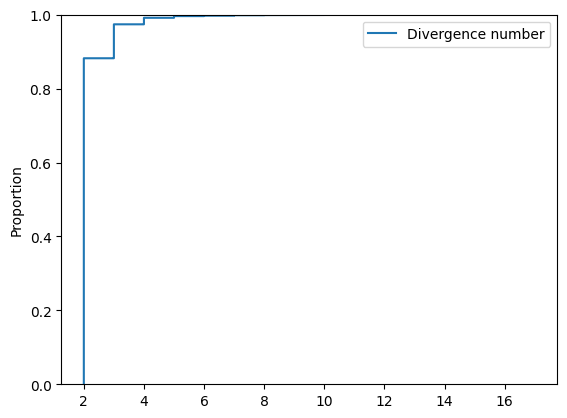

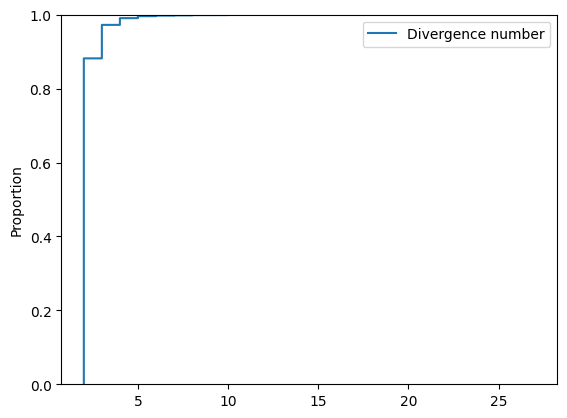

In [10]:
import seaborn as sns

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_len_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_len_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

def df_get_lowest_hop_number_where_lists_diverge(df: pd.DataFrame) -> int:
    columns = df.loc[:, ["HOP_IP_ADDRESSES", "HOP_NUMBERS"]]
    list_of_lists = list()
    # Create list of lists
    for row in columns.itertuples():
        ip_addresses: list = str(row[1]).split()
        hop_numbers: list = str(row[2]).split()
        # Create list of (ip-address, hop-number) tuples
        list_of_pairs: list = [(ip, hop_numbers[idx]) for idx, ip in enumerate(ip_addresses)]
        list_of_lists.append(list_of_pairs)
    
    #longest_list_len = get_len_of_longest_list(list_of_lists)
    shortest_list_len = get_len_of_shortest_list(list_of_lists)
 
    # Compare list of lists and return the index where they diverge
    for idx in range(shortest_list_len):
        first_list_of_pairs = list_of_lists[0][idx]
        for li in list_of_lists[1:]:
            if first_list_of_pairs != li[idx]:
                hop_numbers = list()
                for i in list_of_lists:
                    # Get the second item in the tuple, aka the hop_number
                    hop_numbers.append(i[idx][1])
                return min(hop_numbers)
    # If we got this far, the hops did not diverge
    return None

for flow_label in FLOW_LABELS:
    divergence_data = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        divergence_data.append(
            df_get_lowest_hop_number_where_lists_diverge(dst_df))
    # Create CDF Plot
    ndiv_count = divergence_data.count(None)
    res = [int(i) for i in divergence_data if i != None]
    sns.ecdfplot(data=res, label=f"Flow label: {flow_label}\nHop Divergence number")
    plt.legend()
    plt.show()

## Flow label distributions
## VP: blr

TracerouteStatistics(num_rows_total=200, num_cycles=27, num_loops=94, num_fl_changes=188, num_asns_traversed=0)


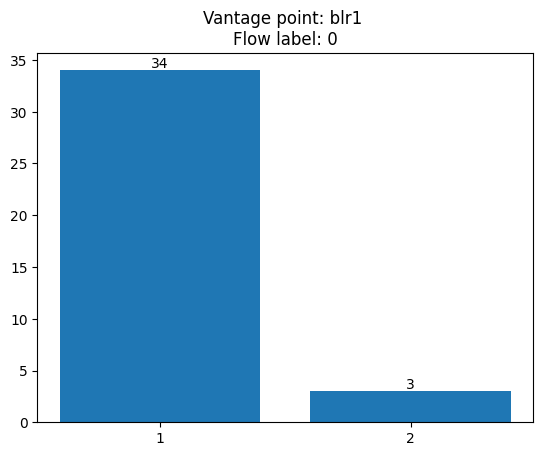

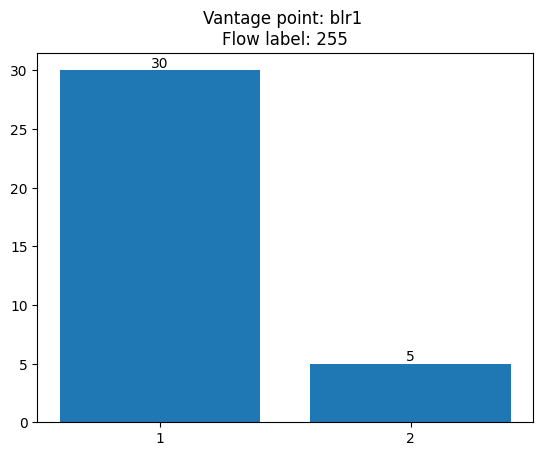

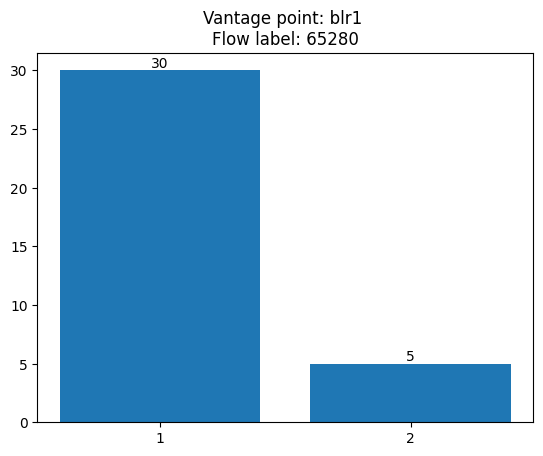

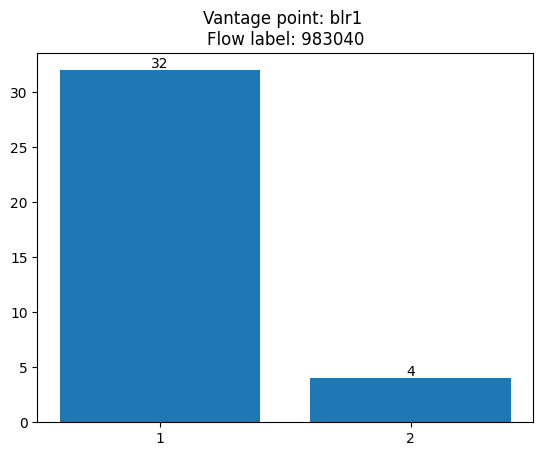

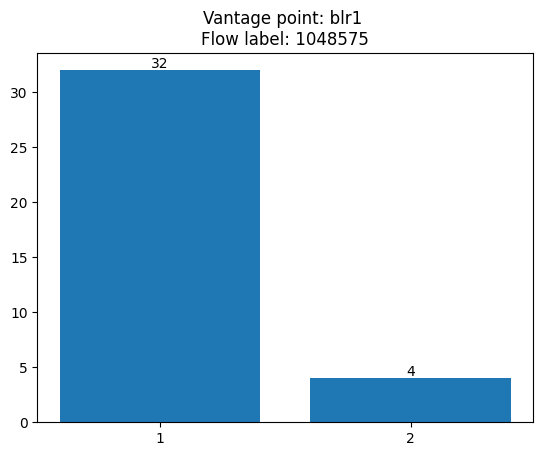

In [4]:
importlib.reload(util)
#df: pd.DataFrame = sq.load_single(Databases.ams)
stats = util.create_stats(df)
print(stats.__repr__())
for flow_label in classdef.FlowLabels:
    util.create_flow_label_distribution(flow_label, vp.blr)

# At what hops to the paths diverge?

In [ ]:
print("Some code here")

## Flow label distributions
## VP: fra

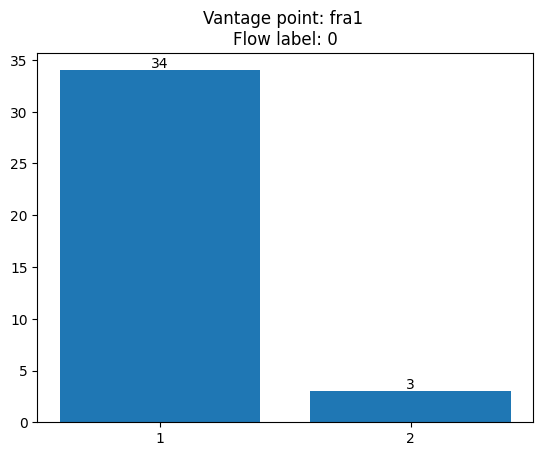

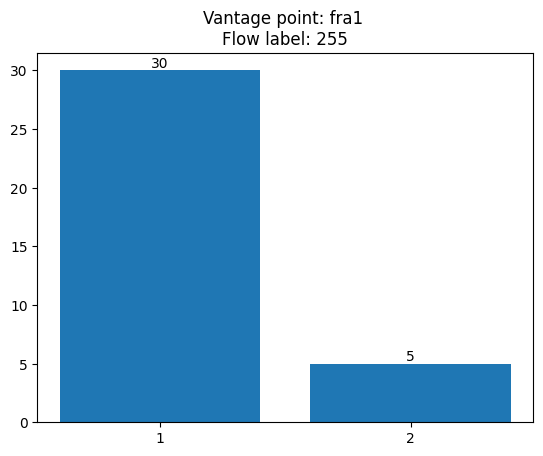

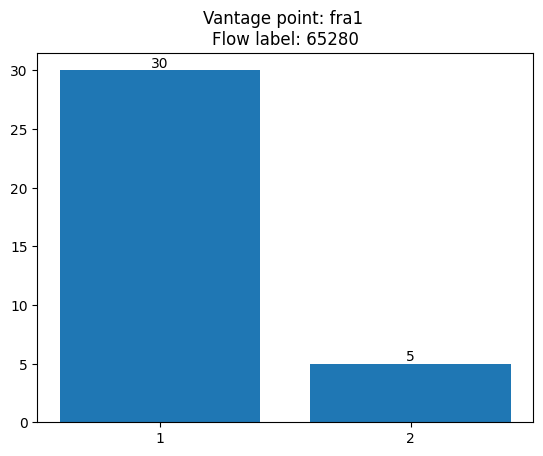

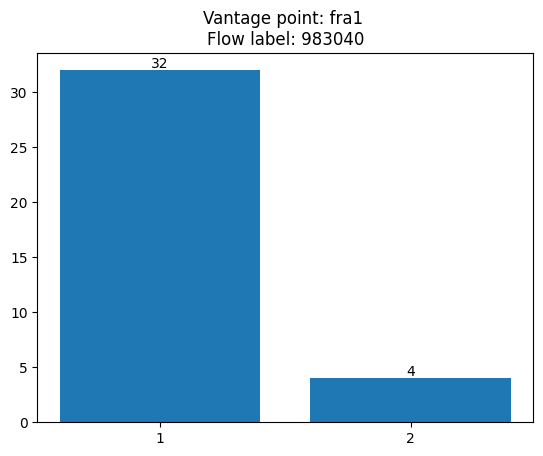

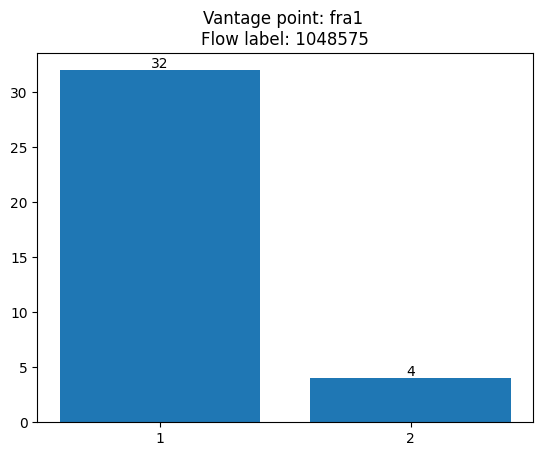

In [19]:
for flow_label in FlowLabels:
    create_flow_label_distribution(flow_label, vp.fra)

## Flow label distributions
## VP: lon

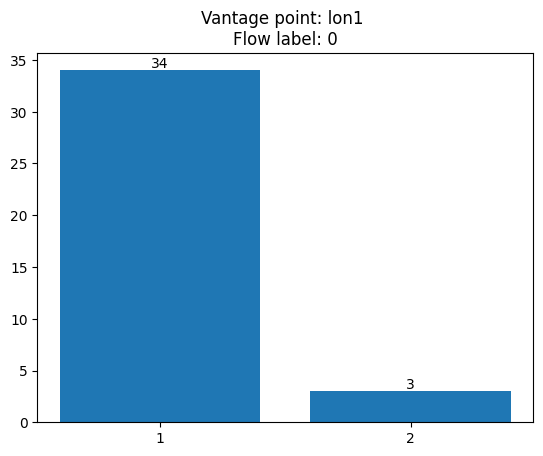

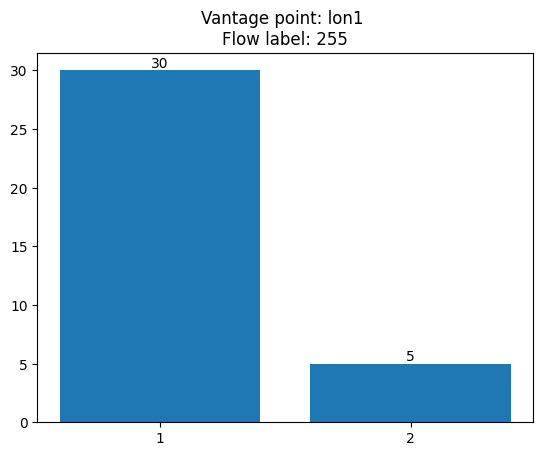

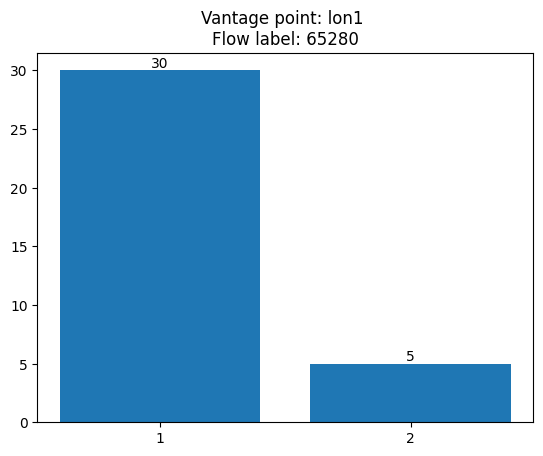

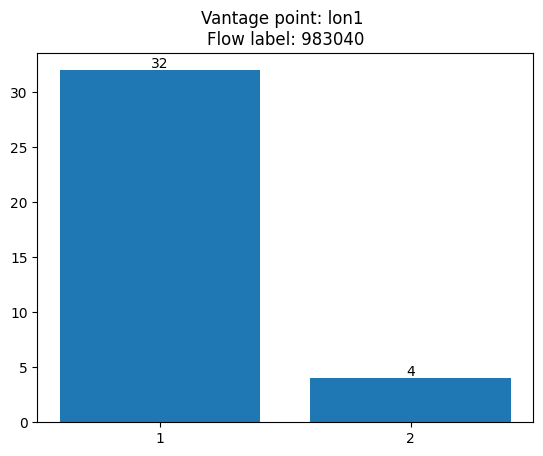

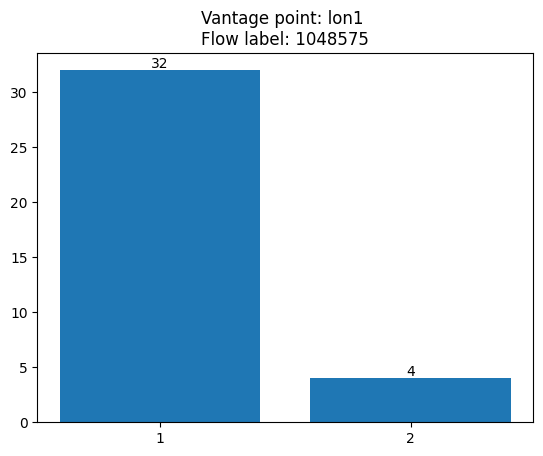

In [20]:
for flow_label in FlowLabels:
    create_flow_label_distribution(flow_label, vp.lon)

## Flow label distributions
## VP: nyc

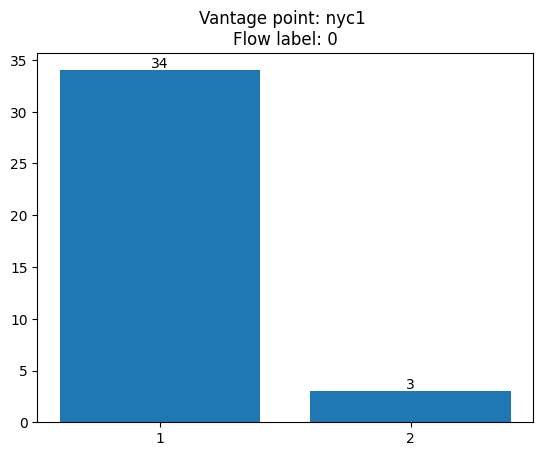

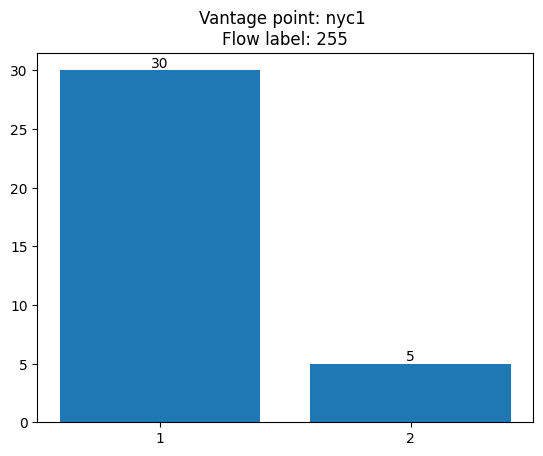

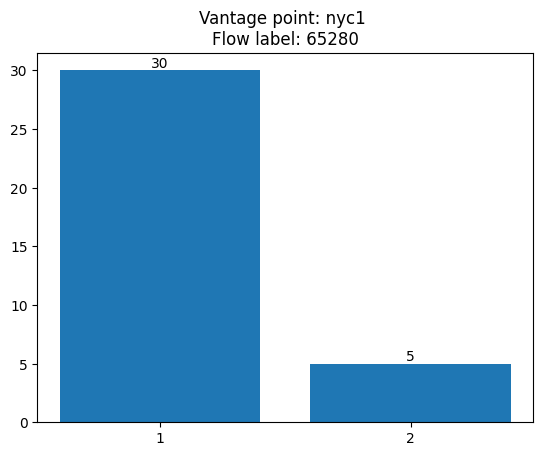

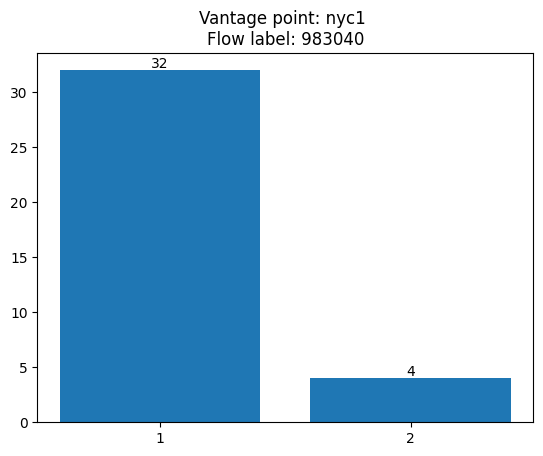

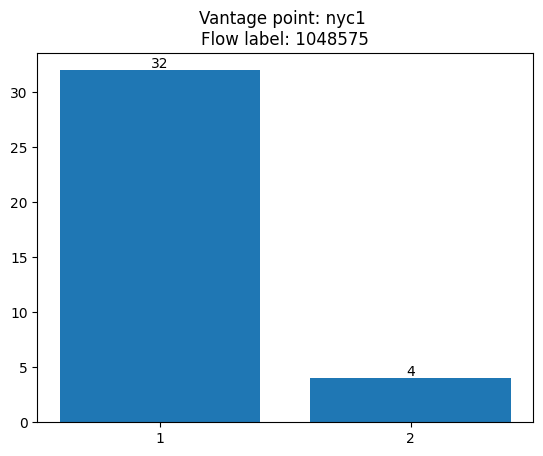

In [21]:
for flow_label in FlowLabels:
    create_flow_label_distribution(flow_label, vp.nyc)

## Flow label distributions
## VP: sfo

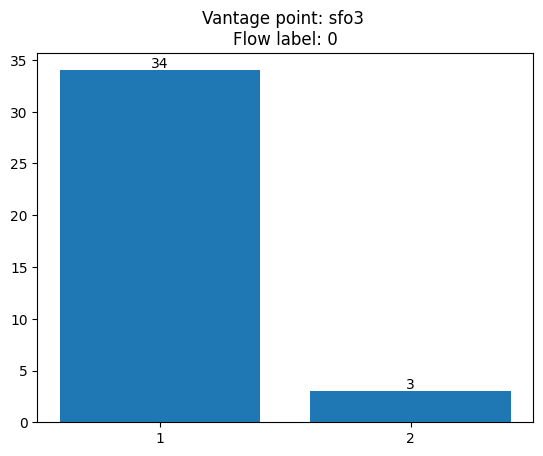

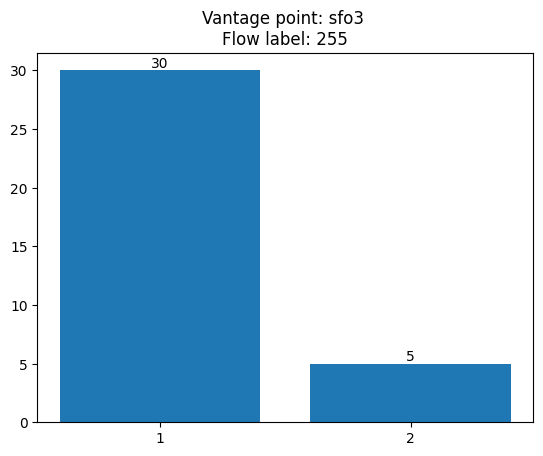

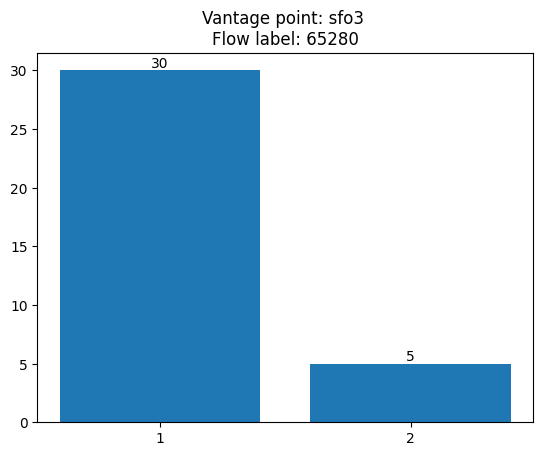

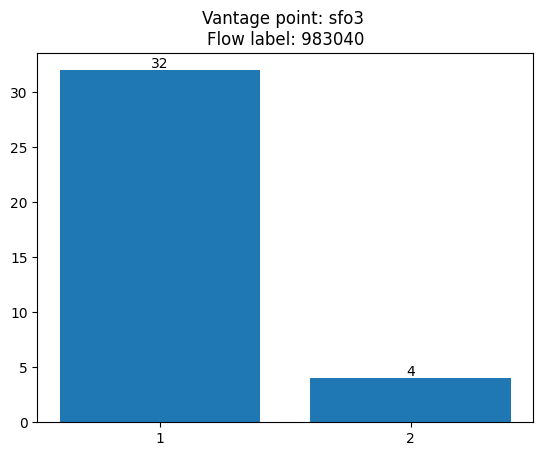

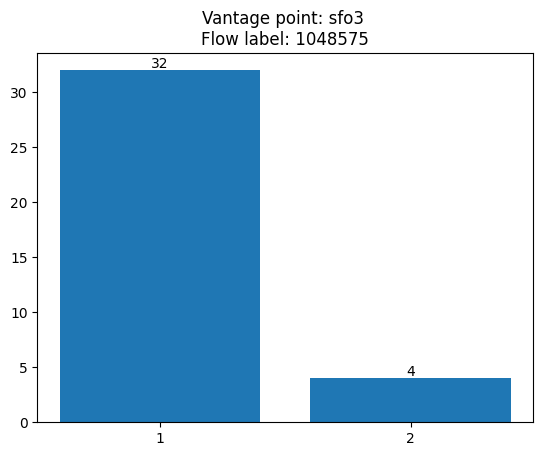

In [22]:
for flow_label in FlowLabels:
    create_flow_label_distribution(flow_label, vp.sfo)


## Flow label distributions
## VP: sgp

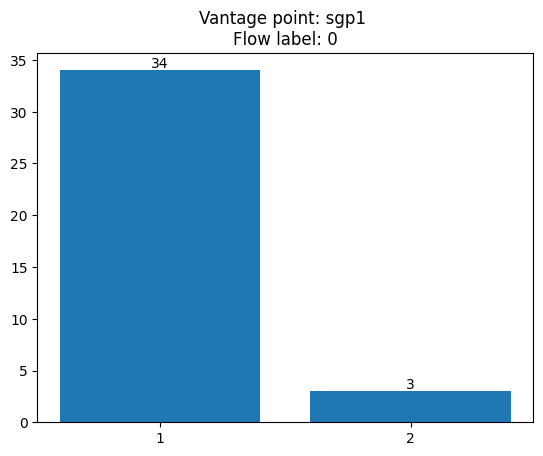

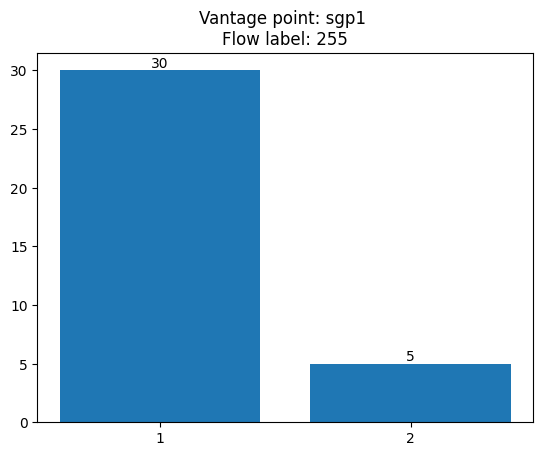

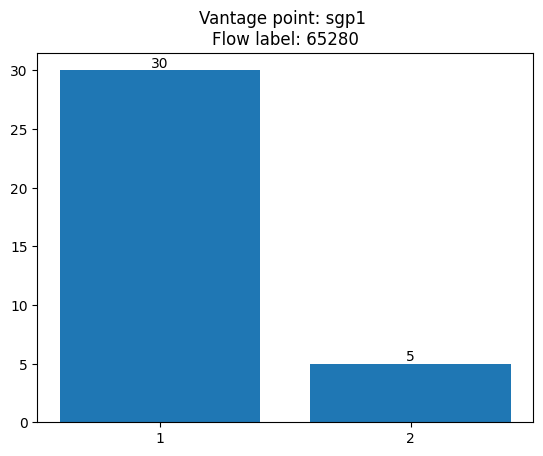

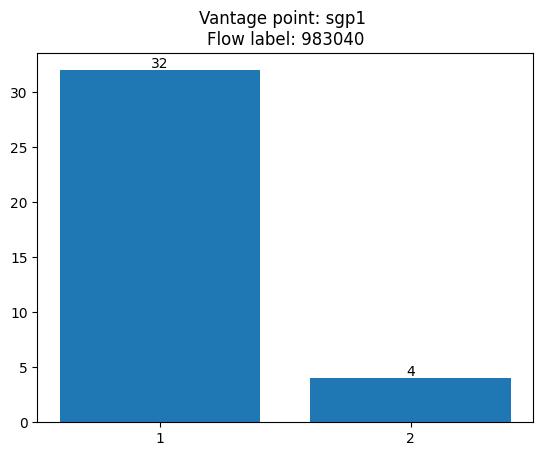

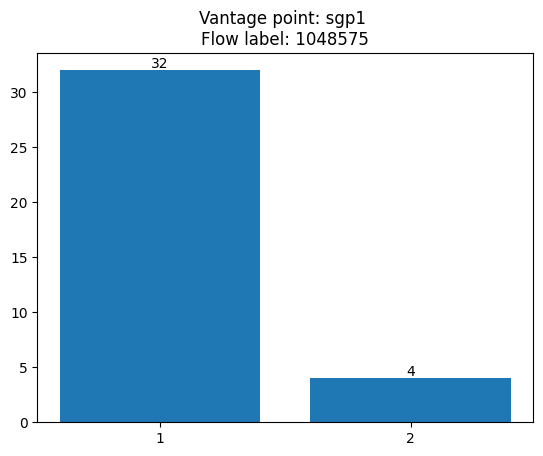

In [23]:

for flow_label in FlowLabels:
    create_flow_label_distribution(flow_label, vp.sgp)


## Flow label distributions
## VP: tor

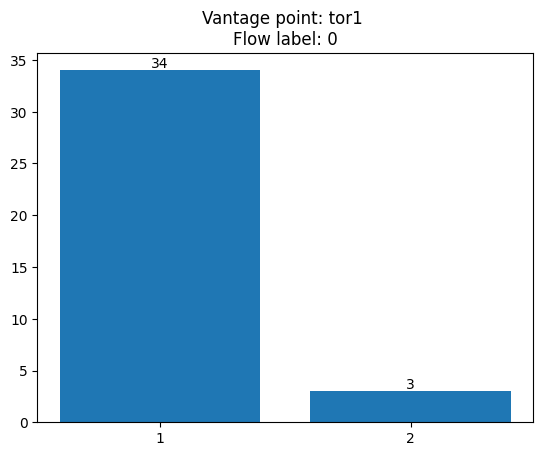

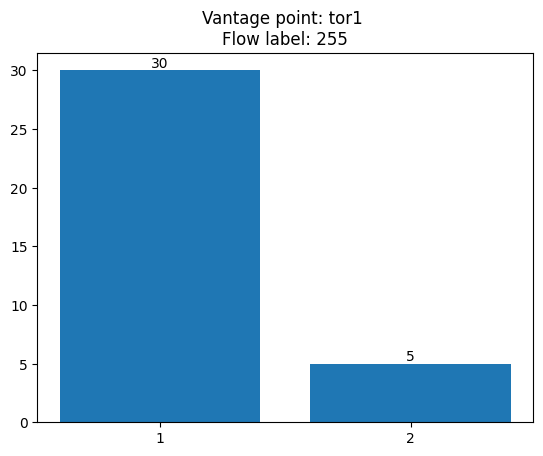

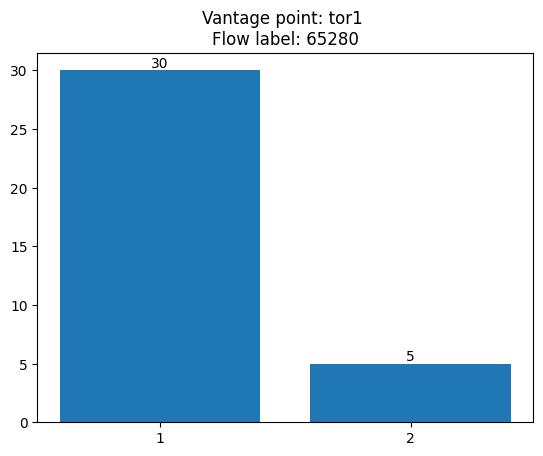

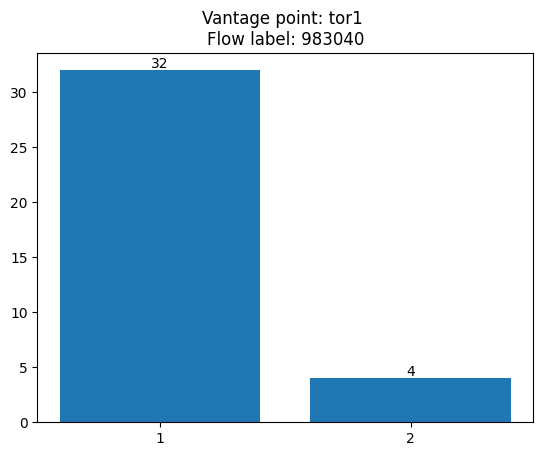

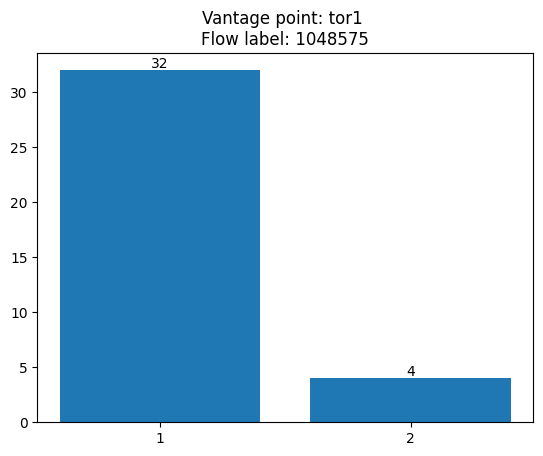

In [24]:

for flow_label in FlowLabels:
    create_flow_label_distribution(flow_label, vp.tor)